In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, AUC
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib

print(f"TensorFlow Version: {tf.__version__}")


TensorFlow Version: 2.18.0


In [10]:
data_dir = pathlib.Path('Squirrel_Classifier_Data')

In [11]:
train_dir = data_dir / 'Training'
validation_dir = data_dir / 'Validation'
test_dir = data_dir / 'Testing'

In [12]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 25 
LEARNING_RATE = 0.0001

In [13]:
try:
    CLASS_NAMES = sorted([item.name for item in train_dir.glob('*') if item.is_dir()])
    NUM_CLASSES = len(CLASS_NAMES)
    if NUM_CLASSES == 0:
        raise ValueError("В директории не найдено папок с классами.")
    print(f"Найденные классы ({NUM_CLASSES}): {CLASS_NAMES}")
except Exception as e:
    print(f"Ошибка при определении классов: {e}")
    raise

Найденные классы (6): ['chipmunk', 'flying', 'fox', 'grey', 'ground', 'red']


In [14]:
# Обучающий датасет
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='categorical',
  class_names=CLASS_NAMES,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# Валидационный датасет
val_ds = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  labels='inferred',
  label_mode='categorical',
  class_names=CLASS_NAMES,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# Тестовый датасет
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  label_mode='categorical',
  class_names=CLASS_NAMES,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  shuffle=False)

print(f"Имена классов, определенные загрузчиком: {train_ds.class_names}")
assert train_ds.class_names == CLASS_NAMES


Found 2920 files belonging to 6 classes.
Found 600 files belonging to 6 classes.
Found 300 files belonging to 6 classes.
Имена классов, определенные загрузчиком: ['chipmunk', 'flying', 'fox', 'grey', 'ground', 'red']


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
  ],
  name="data_augmentation",
)


/opt/anaconda3/envs/my-env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
METRICS = [
    CategoricalAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc', multi_label=True, num_labels=NUM_CLASSES)
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)

In [22]:
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath='best_model_epoch_{epoch:02d}_valloss_{val_loss:.2f}.keras',
#     save_weights_only=False,
#     monitor='val_loss',
#     mode='min',
#     save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
    # callbacks=[model_checkpoint_callback]
)

Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 0.2213 - auc: 0.5680 - loss: 2.0708 - precision: 0.2034 - recall: 0.0834 - val_accuracy: 0.3183 - val_auc: 0.7194 - val_loss: 1.6034 - val_precision: 0.3585 - val_recall: 0.0317
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - accuracy: 0.3049 - auc: 0.6607 - loss: 1.7397 - precision: 0.3635 - recall: 0.0967 - val_accuracy: 0.4167 - val_auc: 0.8089 - val_loss: 1.4198 - val_precision: 0.6410 - val_recall: 0.0833
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.3797 - auc: 0.7308 - loss: 1.5560 - precision: 0.5025 - recall: 0.1391 - val_accuracy: 0.5317 - val_auc: 0.8649 - val_loss: 1.2597 - val_precision: 0.8220 - val_recall: 0.1617
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.4272 - auc: 0.7633 - loss: 1.4744 - precision: 0.5804 - recall: 0.2036 - val_accuracy: 0.5883 - val_auc: 0.8946 - val_loss: 1.1635 - val_precision: 0.8545 - val_recall: 0.2350
Epoch 5/25
92/92 ━━━━━━━━━━━

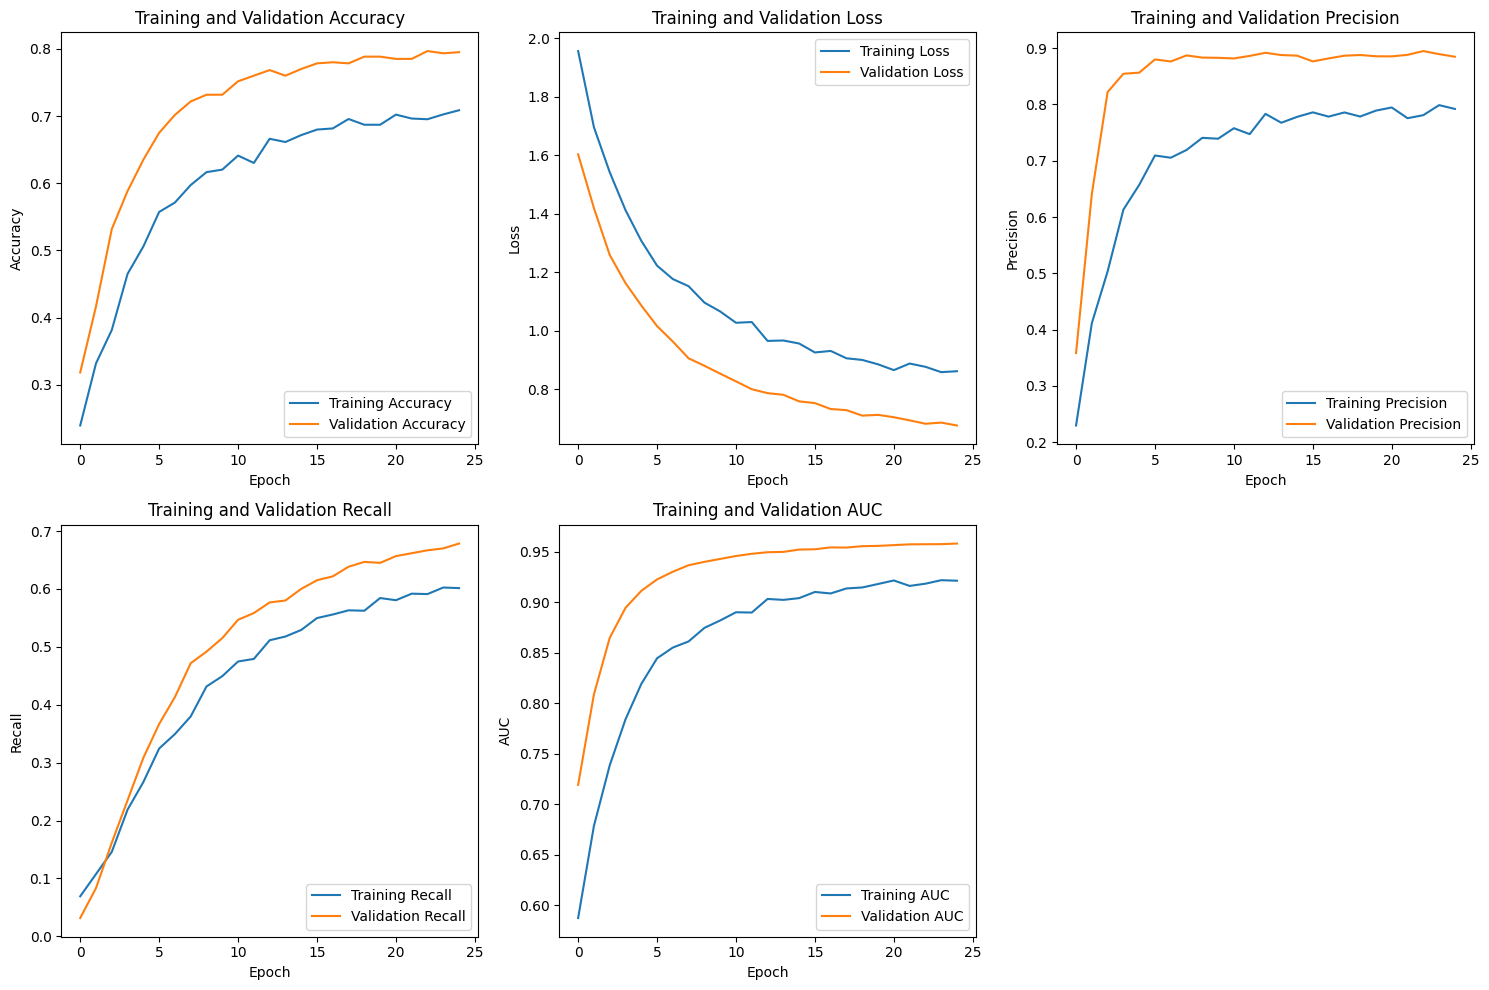

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history.get('precision') 
val_precision = history.history.get('val_precision')
recall = history.history.get('recall')
val_recall = history.history.get('val_recall')
auc = history.history.get('auc')
val_auc = history.history.get('val_auc')

epochs_range = range(len(acc))

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

if precision and val_precision:
    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, precision, label='Training Precision')
    plt.plot(epochs_range, val_precision, label='Validation Precision')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')

if recall and val_recall:
    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, recall, label='Training Recall')
    plt.plot(epochs_range, val_recall, label='Validation Recall')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')

if auc and val_auc:
    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, auc, label='Training AUC')
    plt.plot(epochs_range, val_auc, label='Validation AUC')
    plt.legend(loc='lower right')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')

plt.tight_layout()
plt.show()

In [24]:
print("\nОценка модели на тестовых данных:")
results = model.evaluate(test_ds, verbose=1)

print("\nМетрики на тестовых данных:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")


Оценка модели на тестовых данных:
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.7470 - auc: 0.6460 - loss: 0.7193 - precision: 0.8283 - recall: 0.6336

Метрики на тестовых данных:
loss: 0.6188
compile_metrics: 0.7933


In [25]:
model_save_path_before_finetune = 'modelv4.keras'
model.save(model_save_path_before_finetune)

In [26]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
print(f"Разморожены слои базовой модели начиная с {fine_tune_at}.")

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10),
              metrics=METRICS)

model.summary()

Разморожены слои базовой модели начиная с 100.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 1,869,126 (7.13 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [27]:
fine_tune_epochs = 10 # 
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1] + 1,
                         validation_data=val_ds)
                         # callbacks=[model_checkpoint_callback]

Epoch 26/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 288ms/step - accuracy: 0.6233 - auc: 0.9014 - loss: 1.1514 - precision: 0.7366 - recall: 0.5008 - val_accuracy: 0.7867 - val_auc: 0.9622 - val_loss: 0.6422 - val_precision: 0.8601 - val_recall: 0.6967
Epoch 27/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 300ms/step - accuracy: 0.6639 - auc: 0.9143 - loss: 0.9217 - precision: 0.7886 - recall: 0.5487 - val_accuracy: 0.7867 - val_auc: 0.9629 - val_loss: 0.6308 - val_precision: 0.8509 - val_recall: 0.7133
Epoch 28/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 308ms/step - accuracy: 0.7171 - auc: 0.9312 - loss: 0.8255 - precision: 0.8151 - recall: 0.5921 - val_accuracy: 0.7883 - val_auc: 0.9636 - val_loss: 0.6226 - val_precision: 0.8488 - val_recall: 0.7300
Epoch 29/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step - accuracy: 0.7209 - auc: 0.9358 - loss: 0.7823 - precision: 0.7985 - recall: 0.6052 - val_accuracy: 0.7933 - val_auc: 0.9645 - val_loss: 0.6091 - val_precision: 0.8492 - val_recall: 0.7417
Epoch 30/35
92/92 ━━━━━━

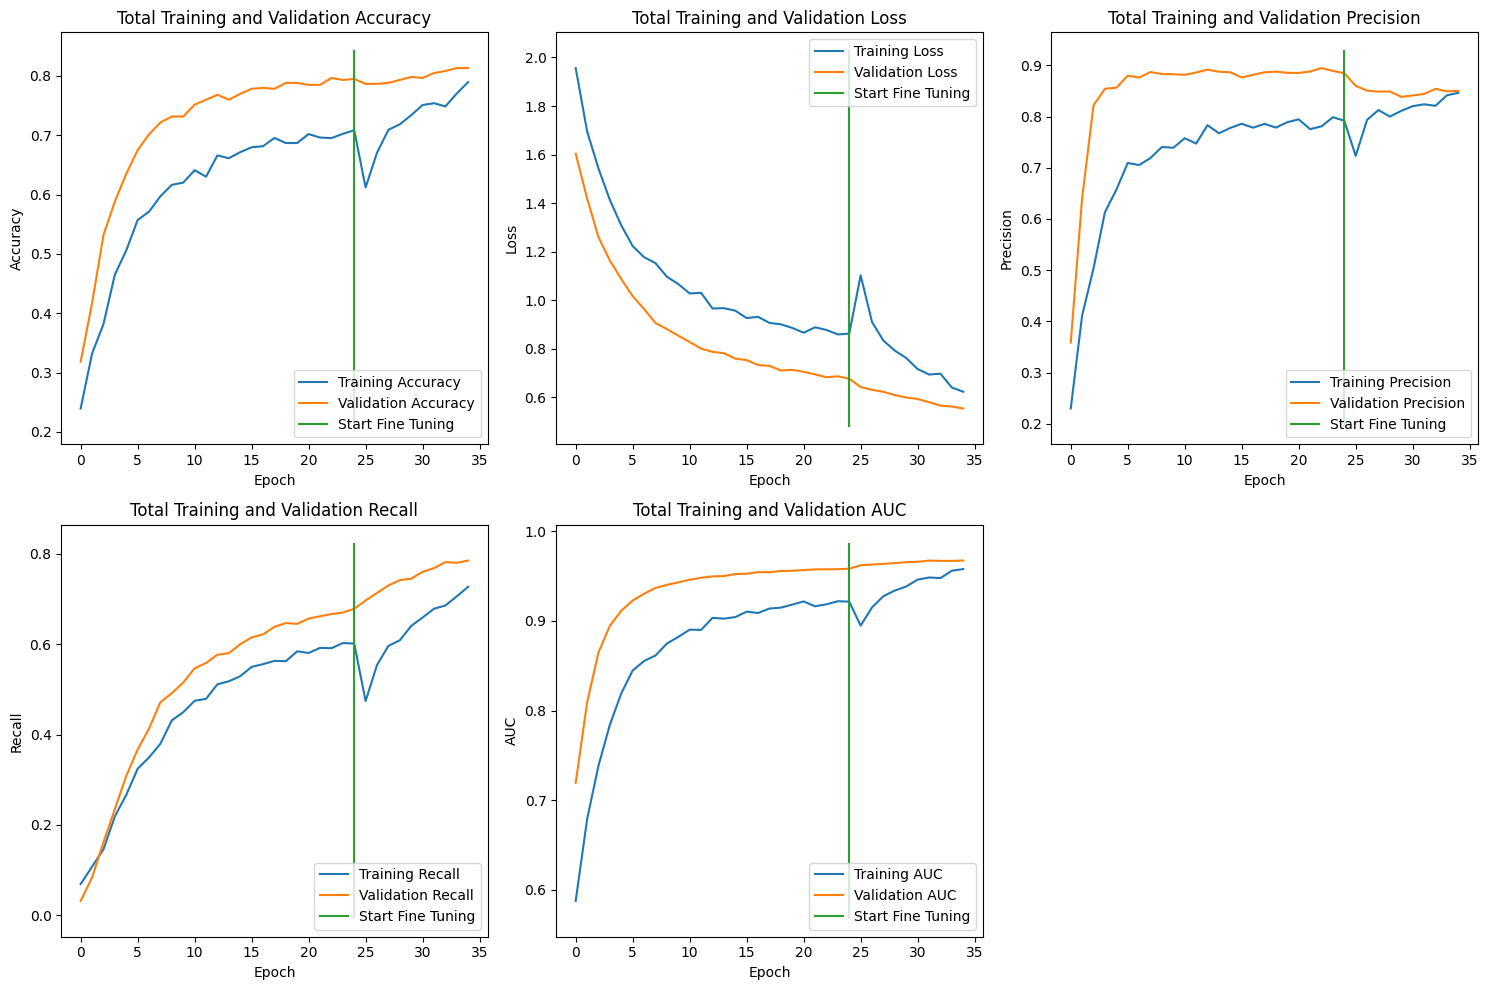

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

if 'precision' in history_fine.history:
    precision += history_fine.history['precision']
    val_precision += history_fine.history['val_precision']
if 'recall' in history_fine.history:
    recall += history_fine.history['recall']
    val_recall += history_fine.history['val_recall']
if 'auc' in history_fine.history:
    auc += history_fine.history['auc']
    val_auc += history_fine.history['val_auc']

epochs_range_total = range(total_epochs)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs_range_total, acc, label='Training Accuracy')
plt.plot(epochs_range_total, val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Total Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2, 3, 2)
plt.plot(epochs_range_total, loss, label='Training Loss')
plt.plot(epochs_range_total, val_loss, label='Validation Loss')
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Total Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

if precision and val_precision:
    plt.subplot(2, 3, 3)
    plt.plot(epochs_range_total, precision, label='Training Precision')
    plt.plot(epochs_range_total, val_precision, label='Validation Precision')
    plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Total Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')

if recall and val_recall:
    plt.subplot(2, 3, 4)
    plt.plot(epochs_range_total, recall, label='Training Recall')
    plt.plot(epochs_range_total, val_recall, label='Validation Recall')
    plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Total Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')

if auc and val_auc:
    plt.subplot(2, 3, 5)
    plt.plot(epochs_range_total, auc, label='Training AUC')
    plt.plot(epochs_range_total, val_auc, label='Validation AUC')
    plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Total Training and Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')


plt.tight_layout()
plt.show()

In [29]:
print("\nПовторная оценка модели на тестовых данных после fine-tuning:")
results_fine = model.evaluate(test_ds, verbose=1)

print("\nФинальные метрики на тестовых данных после fine-tuning:")
for name, value in zip(model.metrics_names, results_fine):
    print(f"{name}: {value:.4f}")


Повторная оценка модели на тестовых данных после fine-tuning:
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.8043 - auc: 0.6565 - loss: 0.5020 - precision: 0.8491 - recall: 0.7518

Финальные метрики на тестовых данных после fine-tuning:
loss: 0.4564
compile_metrics: 0.8500


In [30]:
model_save_path = 'modelv4.1.keras'
model.save(model_save_path)